In [1]:
import project_path

import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import os
import re
import pandas as pd
import seaborn as sns
import sqlite3 as sl
from tqdm import tqdm
from typing import List, Any, Tuple, Dict

from lib.utils import iterate_over
from lib.utils import load_config_and_check
from lib.inspector import Inspector

%load_ext autoreload
%autoreload 2

# Parameters

In [2]:
EXP_FOLDER = "qmt_v20" 
SQL_PATH = os.path.join("..", "data", EXP_FOLDER, "qfl.db")
#LOG_PATH = os.path.join("..", "data", EXP_FOLDER, "log_fuzzy.txt")
SQL_CONNECTION = sl.connect(SQL_PATH)


In [3]:
OUT_FOLDER = "../data/paper_images"
PVAL_COL = "divergence.ks.p-value" 
ALPHA_LEVEL = 0.05

MR_ALIAS = {
    "ChangeTargetBasis": "ChangeOfGateSet",
    "ToQasmAndBack": "Roundtrip conversion via QASM",
    "ChangeBackend": "Change of backend",
    "ChangeCouplingMap": "Change of coupling map",
    "ChangeOptLevel": "Change of optimization level",
    "ChangeTargetBasis": "Change of gate set",
    "ChangeQubitOrder": "Change of qubit order",
    "RunIndependentPartitions": "Partitioned execution",
    "InjectNullEffect": "Inject null-effect operations",
    "AddUnusedRegister": "Add quantum register",
    "InjectParameters": "Inject parameters",
    
}


# Load Data

In [4]:
df_crash = pd.read_sql("""SELECT * from CRASHDATA""", SQL_CONNECTION)
df_data = pd.read_sql("""SELECT * from QFLDATA""", SQL_CONNECTION)
#LOG_CONTENT = open(LOG_PATH, 'r').read()
#LOG_LINES = LOG_CONTENT.split("\n")
print(f"Total (potentially divergent) comparisons: {len(df_data)}")
print(f"Total crash in programs: {len(df_crash)}")
print(f"\tcrashing source: {len(df_crash[~df_crash['exceptions.source'].isna()])}")
print(f"\tcrashing follow-up: {len(df_crash[~df_crash['exceptions.followup'].isna()])}")

Total (potentially divergent) comparisons: 61487
Total crash in programs: 24889
	crashing source: 0
	crashing follow-up: 24889


In [5]:
df_generated_programs = pd.concat(
    [
        df_data.assign(generated_a_crash=False),
        df_crash.assign(generated_a_crash=True)
    ],
    axis=0
)

total_duration_sec = \
    (df_generated_programs["abs_start_time"].max() 
     - df_generated_programs["abs_start_time"].min())
total_duration_days = total_duration_sec / (3600 * 24)
print(f"The fuzzying process lasted {total_duration_days:.2f} days")
#df_generated_programs.info()

The fuzzying process lasted 3.75 days


# RQ: how many warnings in a fixed budget time (2 days)?
2 days = as used by QDiff 

In [6]:
from lib.inspector import get_alarms_with_method

def get_program_within_first_hours(df, n_hours: int, col_time: str = "abs_start_time"):
    """Get the programs generated in the first n hours."""
    df = df.sort_values(by=col_time)
    approach_start_time = int(df[col_time].min())
    df["time_since_start"] = df[col_time].apply(
        lambda c_program_start_time: c_program_start_time - approach_start_time
    )
    return df[df["time_since_start"] < 3600 * n_hours]

N_HOURS = 48

df_first_2_days = get_program_within_first_hours(
    df=df_generated_programs,
    n_hours=N_HOURS
)
df_first_2_days_crash = df_first_2_days[df_first_2_days["generated_a_crash"]]
df_first_2_days_complete = df_first_2_days[~df_first_2_days["generated_a_crash"]]

print(f"In the first {N_HOURS} hours we tested {len(df_first_2_days)} program pairs")

n_tot_pairs = len(df_first_2_days)
n_crash = len(df_first_2_days_crash)
n_complete_execution = len(df_first_2_days_complete)
assert n_crash + n_complete_execution == n_tot_pairs

perc_crash = (n_crash / n_tot_pairs) * 100
perc_complete_execution = (n_complete_execution / n_tot_pairs) * 100

print(f"{n_crash} ({perc_crash:.2f} %) crashes")
print(f"{n_complete_execution} ({perc_complete_execution:.2f} %) complete executions")


n_crash_source = len(df_first_2_days_crash[~df_first_2_days_crash['exceptions.source'].isna()])
n_crash_followup = len(df_first_2_days_crash[~df_first_2_days_crash['exceptions.followup'].isna()]) 
perc_crash_source = (n_crash_source / n_tot_pairs) * 100
perc_crash_followup = (n_crash_followup / n_tot_pairs) * 100

PVAL_COL = "divergence.ks.p-value"
ALPHA_LEVEL = 0.05

#program_ids_bonferroni = get_alarms_with_method(
#    df=df_first_2_days_complete, 
#    pval_col=PVAL_COL,
#    alpha_level=ALPHA_LEVEL,
#    method='bonferroni')
#n_divergence = len(program_ids_bonferroni)
n_divergence = len(df_first_2_days_complete[
    df_first_2_days_complete[PVAL_COL] < ALPHA_LEVEL
])
perc_divergence = (n_divergence / n_tot_pairs) * 100

print("% RQ1")
print("\\newcommand{\percCrashesBenchmark}{"+f"{perc_crash:.1f}"+"\%}")
print("\\newcommand{\\totalTestedProgramPairs}{"+f"{len(df_first_2_days):,.0f}"+"}")
print("\\newcommand{\\totalPairsWithDistrDifference}{"+f"{n_divergence:,.0f}"+"}")

print("""
\\begin{table}[t]
  \centering
  % """ + EXP_FOLDER + """
  \caption{Distribution of warnings produced over two days.}
  \\begin{tabular}{@{}lrr@{}}
  \\toprule
  & Number & Percentage \\\\
  \\midrule
  Tested program pairs& """ + f"{len(df_first_2_days):,.0f}"+ """& 100.0\\% \\\\
  \hspace{1em} $\hookrightarrow$ Crashes in source program & """ + f"{n_crash_source:,.0f} & {perc_crash_source:.1f} \\%"+ """\\\\
  \hspace{1em} $\hookrightarrow$ Crashes in follow-up program & """ + f"{n_crash_followup:,.0f} & {perc_crash_followup:.1f} \\%"+ """\\\\
  \hspace{1em} $\hookrightarrow$ Successful executions & """ + f"{n_complete_execution:,.0f} & {perc_complete_execution:.1f} \\%"+ """\\\\
  \hspace{3em} $\hookrightarrow$ Distribution differences & """ + f"{n_divergence:,.0f} & {perc_divergence:.1f} \\%"+ """\\\\
  \\bottomrule
  \end{tabular}
  \label{tab:warnings_distribution}
\end{table}
""")

In the first 48 hours we tested 50591 program pairs
14651 (28.96 %) crashes
35940 (71.04 %) complete executions
% RQ1
\newcommand{\percCrashesBenchmark}{29.0\%}
\newcommand{\totalTestedProgramPairs}{50,591}
\newcommand{\totalPairsWithDistrDifference}{537}

\begin{table}[t]
  \centering
  % qmt_v20
  \caption{Distribution of warnings produced over two days.}
  \begin{tabular}{@{}lrr@{}}
  \toprule
  & Number & Percentage \\
  \midrule
  Tested program pairs& 50,591& 100.0\% \\
  \hspace{1em} $\hookrightarrow$ Crashes in source program & 0 & 0.0 \%\\
  \hspace{1em} $\hookrightarrow$ Crashes in follow-up program & 14,651 & 29.0 \%\\
  \hspace{1em} $\hookrightarrow$ Successful executions & 35,940 & 71.0 \%\\
  \hspace{3em} $\hookrightarrow$ Distribution differences & 537 & 1.1 \%\\
  \bottomrule
  \end{tabular}
  \label{tab:warnings_distribution}
\end{table}



# RQ: Real bugs? (Table with warnings)
See the warning folder with programs and reported bug issues screens.

In [7]:
# create latex table
PATH_DATASET = "../miscellanea/table_artifacts/Qiskit_Bug_Dataset - main_dataset.csv"
df_bugs = pd.read_csv(PATH_DATASET)
df_bugs = df_bugs.sort_values(by=[
    "status"
], ascending=True)
df_bugs = df_bugs.reset_index(drop=True)
df_bugs = df_bugs.reset_index(drop=False)
df_bugs = df_bugs.fillna("-")
df_bugs.head()

,index,bug_id,experiment,program_id,date_found,date_reported,manifestation,hook_hint,crash_category,present_also_in_final_run,root_cause,API_usage,mr_used,bug_description,link_to_issue,developer_reaction,developer comment,component,known_before,status
0,0,01_accidental,qmt_v01,-,8-feb-22,8-feb-22,timeout,-,-,False,inefficient translation basis,non-existent gate names,ChangeTargetBasis,"Compiler hangs (infinite loop), when transpile...",https://github.com/Qiskit/qiskit-terra/issues/...,comment; confirmed; similar issue; fix is read...,"""This is similar to #5539, perhaps a slightly ...",-,duplicate (different manifestation),confirmed
1,1,12_799857,qmt_v12,799857e40bee4c7db1b65a3c190d67ca,9-mar-22,9-mar-22,crash,Cannot find gate definition for 'c3sx',Cannot find gate definition for 'c3sx',True,C3SXGate,correct,ToQasmAndBack,Qasm exporter doesn't generate the definition ...,https://github.com/Qiskit/qiskit-terra/issues/...,comment; confirmed; duplicate,"""This is a duplicate of #7148, which does have...",-,duplicate,confirmed
2,2,11_74343b,qmt_v11,74343b53af17413d86dbdf57b8f6da86,8-mar-22,8-mar-22,crash,Duplicate declaration for gate 'rzx',Duplicate declaration for gate 'rzx',True,ECRGate,correct,ToQasmAndBack,Qasm exporter fails with `ECRGate` `QasmError:...,https://github.com/Qiskit/qiskit-terra/issues/...,comment; confirmed; fix coming.,"""QASM 2 exporter has had this problem for a lo...",-,duplicate (different manifestation),confirmed
3,3,09_462576,qmt_v09,462576d5c97842feb25cd7a79d659969,8-mar-22,8-mar-22,crash,Cannot bind parameters,Cannot bind parameters not present in the circuit,True,C3XGate,correct,InjectParameters,C3XGate doesn't bind the angle parameter `Circ...,https://github.com/Qiskit/qiskit-terra/issues/...,comment; confirmed; uncomplete job; fix coming.,"""it should raise a DeprecationWarning due to p...",-,new,confirmed
4,4,09_f8a306,qmt_v09,f8a306d8953f4e46a2b8ecec434f9cc0,8-mar-22,-,crash,"Mismatch between run_config.parameter_binds, u...",Mismatch between parameter_binds,True,CUGate,correct,InjectParameters,CUGate's params getter does not comply with ci...,https://github.com/Qiskit/qiskit-terra/issues/...,duplicated; confirmed by developer,-,-,duplicate,confirmed


In [8]:
ANONYMOUS = True
KEEP_ONLY_CONFIRMED = True 
KEEP_ONLY_CRASHES = True 
REMOVE_FALSE_POSITIVES = True

col_renaming = {
    "index": "ID",
    "link_to_issue": "Report",
    "status": "Status",
    "known_before": "Novelty",
    #"API_usage": "API usage",
    #"manifestation": "How",
    "crash_category": "Crash message",
    "mr_used": "Metamorphic transformations",
    #"bug_description": "Description",
    #"root_cause": "Root Cause",
}

if ANONYMOUS:
    df_bugs["link_to_issue"] = "#XXXX"
else:
    df_bugs["link_to_issue"] = df_bugs["link_to_issue"].apply(
        lambda e: e.replace("https://github.com/Qiskit/qiskit-terra/issues/", "#")
    )

df_bugs["known_before"] = df_bugs["known_before"].apply(
    lambda e: str(e).replace("duplicate (different manifestation)", "duplicate*")
)

In [9]:
pd.set_option('display.max_colwidth', 1000)

relevant_columns = col_renaming.keys()
df_table = deepcopy(df_bugs)
if KEEP_ONLY_CRASHES:
    df_table = df_table[df_table["manifestation"] == "crash"]
if REMOVE_FALSE_POSITIVES:
    df_table = df_table[~(df_table["status"] == "false positive")]
df_table = df_table.drop(columns='index')  

def replace_MR_names(transf_str):
    new_transf_str = transf_str
    for k, v in MR_ALIAS.items():
        new_transf_str = new_transf_str.replace(k, v)
    return new_transf_str

df_table["mr_used"] = df_table["mr_used"].apply(
    lambda e: replace_MR_names(transf_str=e)
) 
df_table = df_table.reset_index(drop=True)
df_table = df_table.reset_index(drop=False)
df_table = df_table[relevant_columns].rename(columns=col_renaming)
df_table["ID"] = df_table["ID"].apply(lambda e: int(e) + 1)
df_table.head()

import string

print("% RQ2")
for i, row in df_table.iterrows():
    msg = row["Crash message"]
    msg = msg.translate(str.maketrans('', '', string.punctuation))
    msg = ''.join([w.capitalize() for w in msg.lower().split()])
    msg = ''.join(ch for ch in msg if ch.isalpha())
    if msg != "":
        print("\\newcommand{\\ID" + msg + "}{" + str(row["ID"]) + "}")

print("")
table_code = df_table.to_latex(
    column_format='@{}rlllp{5cm}p{7.3cm}@{}',
    index=False)
table_code = re.sub("\s'", " `", table_code)
print(table_code)

% RQ2
\newcommand{\IDCannotFindGateDefinitionForCsx}{1}
\newcommand{\IDDuplicateDeclarationForGateRzx}{2}
\newcommand{\IDCannotBindParametersNotPresentInTheCircuit}{3}
\newcommand{\IDMismatchBetweenParameterbinds}{4}
\newcommand{\IDGateOrOpaqueCallToSubcircuit}{5}
\newcommand{\IDQargsNotInThisCircuit}{6}
\newcommand{\IDInstructionIdNotFound}{7}
\newcommand{\IDTooManySubscriptsInEinsumNumpy}{8}
\newcommand{\IDCannotFindGateDefinitionForRzx}{9}
\newcommand{\IDDuplicateDeclarationForGateRyy}{10}
\newcommand{\IDCannotFindGateDefinitionForUnitary}{11}
\newcommand{\IDCannotFindGateDefinitionForRcccx}{12}

\begin{tabular}{@{}rlllp{5cm}p{7.3cm}@{}}
\toprule
 ID & Report &    Status &    Novelty &                                     Crash message &                                                                Metamorphic transformations \\
\midrule
  1 &  \#XXXX & confirmed &  duplicate &            Cannot find gate definition for `c3sx' &                                                       

# RQ: Contribution of Metamorphic Transformations
How do the different warnings distribute over the MR?
When a program pair fails > attributes 1 point to each MR involved, then count how many “crash-points” each MR got.

In [10]:
import ast

COL_TRANSF = "followup.metamorphic_transformations"

relevant_columns = [
    "program_id",
    "generated_a_crash",
    "exceptions.followup",  
    COL_TRANSF,
    PVAL_COL
]
df = df_generated_programs[relevant_columns]
df.loc[:, COL_TRANSF] = df[COL_TRANSF].apply(ast.literal_eval)
df.loc[:, COL_TRANSF] = df[COL_TRANSF].apply(lambda e: list(set(e)))
df_flat = df.explode(COL_TRANSF)
df_flat.head()

/home/paltenmo/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,program_id,generated_a_crash,exceptions.followup,followup.metamorphic_transformations,divergence.ks.p-value
0,dac1a10f66ad4d7d96d85e8aed8116c6,False,None,ChangeOptLevel,1.000000
0,dac1a10f66ad4d7d96d85e8aed8116c6,False,None,ChangeCouplingMap,1.000000
0,dac1a10f66ad4d7d96d85e8aed8116c6,False,None,ToQasmAndBack,1.000000
1,2a3a0e3151ae481f9bf00521531eeebc,False,None,ChangeQubitOrder,0.578571
2,0ffd6f559939492ea2435d4352b499bb,False,None,ChangeQubitOrder,1.000000


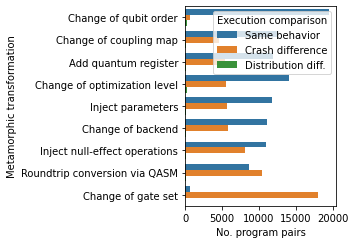

In [11]:
fig, ax = plt.subplots(figsize=(5, 3.5))

def assign_class(row):
    if row["generated_a_crash"]:
        return "Crash difference"
    else:
        if row[PVAL_COL] < ALPHA_LEVEL:
            return "Distribution diff."
    return "Same behavior"


df_flat["Execution comparison"] = df_flat.apply(
    lambda row: assign_class(row),
    axis=1
)

df_flat[COL_TRANSF] = df_flat[COL_TRANSF].apply(
    lambda e: MR_ALIAS[e] if e in MR_ALIAS.keys() else e
)

sns.countplot(
    data=df_flat,
    y=COL_TRANSF,
    hue_order = ["Same behavior", "Crash difference", "Distribution diff."],
    hue='Execution comparison',
    order=df_flat[df_flat['Execution comparison'] == "Crash difference"][COL_TRANSF].value_counts(ascending=True).index,
    #palette=["darkorange", "forestgreen", "dodgerblue"],
    ax=ax
)
ax.set_xlabel("No. program pairs")
ax.set_ylabel("Metamorphic transformation")
#ax.legend(title="Lead to crash")
plt.tight_layout()
#fig.savefig(os.path.join(OUT_FOLDER, "RQ3_quantitative_most_crashing_MR.pdf"))

# RQ: Time Cost per Component

In [12]:
# IDEA: measure the time of each step and create a barchart with percentage and one with absolute values

In [13]:
relevant_time_cols = [
    'program_id',
    'time_exec',
    'source.time_generation',
    #'followup.time_generation', # this attribute is statically copied form source
    'followup.time_metamorph',
    #'divergence.ks.time',
    'generated_a_crash'
]

df_time = df_generated_programs[relevant_time_cols]
df_time.head()

,program_id,time_exec,source.time_generation,followup.time_metamorph,generated_a_crash
0,dac1a10f66ad4d7d96d85e8aed8116c6,0.602342,0.004162,0.022669,False
1,2a3a0e3151ae481f9bf00521531eeebc,1.748649,0.008869,0.043745,False
2,0ffd6f559939492ea2435d4352b499bb,0.364280,0.004916,0.023953,False
3,566cab9dc28640228674c71df7cad526,0.603391,0.006900,0.039534,False
4,1ed4c832cc714b67974c0b32b15447c8,0.759526,0.007959,0.050385,False


In [14]:
df_time_melt = pd.melt(
    df_time, id_vars=['program_id', 'generated_a_crash'], 
    value_vars=relevant_time_cols.remove('program_id'))
df_time_melt["value"] = df_time_melt["value"].apply(lambda e: 1000 * e)
df_time_melt.head(20)

,program_id,generated_a_crash,variable,value
0,dac1a10f66ad4d7d96d85e8aed8116c6,False,time_exec,602.342189
1,2a3a0e3151ae481f9bf00521531eeebc,False,time_exec,1748.648876
2,0ffd6f559939492ea2435d4352b499bb,False,time_exec,364.279979
3,566cab9dc28640228674c71df7cad526,False,time_exec,603.390702
4,1ed4c832cc714b67974c0b32b15447c8,False,time_exec,759.526142
5,d4aec57fb3fe4c4e979013a98d5d8450,False,time_exec,983.742525
6,ac02d65df0f44df28c38452fb20474f2,False,time_exec,300.404136
7,f7cc9181f23d4cc7bd44ad4d57a07e1f,False,time_exec,751.532161
8,a8c6d9d20ced47ba9abecb55c4aaf7b4,False,time_exec,809.211444
9,55af5879445741a8b77242484680c217,False,time_exec,731.259920


% RQ3
\newcommand{\avgTimeMsGenerationAndTransf}{36.8}
\newcommand{\avgTimeMsGenerationOnly}{6.2}
\newcommand{\avgTimeMsTransfOnly}{30.6}


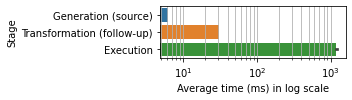

In [15]:
fig, ax = plt.subplots(figsize=(5, 1.5))

mapping = {
    "source.time_generation": 'Generation (source)',
    "followup.time_metamorph": 'Transformation (follow-up)',
    "time_exec": "Execution",
    #"divergence.ks.time": "Divergence Check"
}

sns.barplot(
    data=df_time_melt,
    y='variable',
    x='value',
    order=list(mapping.keys()),
    ax=ax
)

print("% RQ3")
avg_ms_gen_and_transf = df_time_melt[df_time_melt["variable"].isin([
    "source.time_generation", 
    "followup.time_metamorph"]
)].groupby(by="program_id").sum().reset_index()["value"].mean()
print("\\newcommand{\\avgTimeMsGenerationAndTransf}{" + f"{avg_ms_gen_and_transf:.1f}" + "}")

avg_ms_gen_only = df_time_melt[
    df_time_melt["variable"] == "source.time_generation"].reset_index()["value"].mean()
print("\\newcommand{\\avgTimeMsGenerationOnly}{" + f"{avg_ms_gen_only:.1f}" + "}")
avg_ms_transf_only = df_time_melt[
    df_time_melt["variable"] == "followup.time_metamorph"].reset_index()["value"].mean()
print("\\newcommand{\\avgTimeMsTransfOnly}{" + f"{avg_ms_transf_only:.1f}" + "}")

original_labels = ax.get_yticklabels()
ax.set_yticklabels(labels=[
    mapping.get(e._text, e._text)
    for e in original_labels
])
ax.grid(axis='x', which='both')
ax.set_xscale('log')
ax.set_ylabel('Stage')
ax.set_xlabel('Average time (ms) in log scale')

plt.tight_layout()
#fig.savefig(os.path.join(OUT_FOLDER, "RQ4_time_analysis.pdf"))

# Sample some warinings for manual inspection
Pick those which are raised by STATIC THRESHOLD but not by HOLM & CO

In [16]:
program_ids_static = get_alarms_with_method(
    df=df_data, 
    pval_col=PVAL_COL,
    alpha_level=ALPHA_LEVEL,
    method='static')
program_ids_static[:10]

['1a23f0088de542e7a778ea2bbbea3538',
 '2d939ba211fe43868f151e8137dab409',
 'fdc3d59c0e924819ab9809bb4d1c9bd3',
 'bef8386c5f7346eba1df9def780bb84e',
 '6b66a08cb92c42bebaadb1bc5b2c5143',
 '8f10ee1b1f014c89bbf7b012c90ee028',
 'd5515441b35a44dbbddcc39242190db2',
 '0ae6aeaaf6a84682b45578104ee70106',
 'eb42857708c94b41a28fcd3704511f94',
 'ae53f9caeccf45d0a8958aafa5aed828']

In [19]:
raise Exception("Official code is over here. Rest is extra.")

Exception: Official code is over here. Rest is extra.

# Miscellanea

## Circuit image

In [ ]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.tools.visualization import plot_histogram

# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
result.get_counts(circ)

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(7, 2.6))
gs = fig.add_gridspec(1, 24)
ax_circuit = fig.add_subplot(gs[:17])
ax_histogram = fig.add_subplot(gs[17:])

circ.draw(
    output='mpl', 
    justify=None,
    style={"margin": [1.23, 0, 0, 0]},
    ax=ax_circuit
)
#ax_circuit.set_title("Gate Model")


plot_histogram(
    counts, 
    #title='Output Distribution',
    ax=ax_histogram    
)

plt.tight_layout()

#fig.savefig(os.path.join(OUT_FOLDER, "example_circuit.pdf"))

## RQ-A: how many syntactically different programs?
can be generated by QMFuzz in a fixed time (2 days, as used by QDiff [31] for the execution)?

In [ ]:
# IDEA: we could cluster them in different groups (e.g. single circuit, two circuits, etc...)
# IDEA: we could check which gates were used by each group 
# (i.e. plot the statistic about the use of a certain type of gate)
# plot the stats on the length of the sequence of operations, n.qubits

In [ ]:
relevant_columns = [c for c in df_data.columns if c.startswith("source.")]
df_generated_programs = pd.concat(
    [
        df_data[relevant_columns].assign(crash_dataset=False),
        df_crash[relevant_columns].assign(crash_dataset=True)
    ],
    axis=0
)
df_generated_programs.reset_index(drop=True, inplace=True)
df_generated_programs.info()

In [ ]:
def plot_numeric_attirbute(df, attribute, x_label=None, title=None, **pltargs):
    """Show the distplot of the given attribute."""
    ax = sns.histplot(
        data=df,
        x=attribute,
        bins=np.arange(0.5, df_generated_programs[attribute].max() + 1),
        **pltargs
    )
    if x_label:
        ax.set_xlabel(x_label)
    if title:
        ax.set_title(title)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(5,5))

ax_gates, ax_qubits = axes
plot_numeric_attirbute(
    df=df_generated_programs, 
    attribute='source.n_ops', 
    x_label="Number of gates",
    ax=ax_gates)
plot_numeric_attirbute(
    df=df_generated_programs, 
    attribute='source.n_qubits', 
    x_label="Number of qubits",
    color='orange',
    ax=ax_qubits)
plt.tight_layout()
#fig.savefig(os.path.join(OUT_FOLDER, "RQ1_distribution_n_gates_n_qubits.pdf"))

## RQ-B: how effective is the varying-threshold approach in reducing the number of false positives?

In [ ]:
sns.histplot(
    data=df_data,
    x='divergence.ks.p-value'
)

In [ ]:
static_treshold = 0.05

threshold_col = "divergence.ks.p-value"
df_programs_w_static_threshold = df_data[
    df_data[threshold_col] <= static_treshold
]
n_alarms_w_static_threshold = len(df_programs_w_static_threshold)
print(f"STATIC THRESHOLD APPROACH produces {n_alarms_w_static_threshold} alarms.")

In [ ]:
method = 'holm'
pval_col = threshold_col
alpha_level = static_treshold

def get_alarms_with_method(df, pval_col, alpha_level, method):
    """Get the program ids of the warnings raised by a method."""
    df_sorted_pvals = df.sort_values(by=[pval_col])
    k = len(df_sorted_pvals)
    i_star = None
    program_ids = []
    for i, (idx, row) in enumerate(df_sorted_pvals.iterrows()):
        ordinal_i = i + 1
        program_ids.append(row["program_id"])
        P_i = row[pval_col]
        if method == 'holm':
            threshold = alpha_level / (k - ordinal_i + 1)
        elif method == 'bonferroni':
            threshold = alpha_level / (k)
        elif method == 'bh':
            threshold = (alpha_level / (k)) * ordinal_i
        # print(f"(i: {ordinal_i}) current p-value: {P_i} vs threshold: {threshold}")
        elif method == 'static':
            threshold = alpha_level        
        if P_i > threshold:
            i_star = i
            #print(f"i*: {i_star}")
            break
    return program_ids


def count_alarm_with_method(df, pval_col, alpha_level, method):
    """Count the number of warnings raised by a method."""
    return len(get_alarms_with_method(
        df=df,
        pval_col=pval_col,
        alpha_level=alpha_level,
        method=method        
    ))  


def get_first_n(df, col_time, n=1000):
    """Get the first n records as ordered by the time column."""
    return df.sort_values(by=col_time).iloc[:n]

#n_alarms_w_varying_threshold = i_star
#print(f"VARYING THRESHOLD APPROACH produces {n_alarms_w_varying_threshold} alarms.")

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

mapping = {
    "bonferroni": 'Bonferroni',
    "holm": 'Holm',
    "bh": "BH"
}

methods_to_try = ['bonferroni', 'holm', 'bh']
n_alarms_w_methods = [
    count_alarm_with_method(
        df=df_data, 
        pval_col=threshold_col,
        alpha_level=static_treshold,
        method=m) for m in methods_to_try]


n_alarms = [n_alarms_w_static_threshold] + n_alarms_w_methods
bars = ['Static\nthreshold'] + list(map(mapping.get, methods_to_try))
y_pos = np.arange(len(bars))

reductions = [
    ((n_alarms_w_static_threshold - abs_val) / n_alarms_w_static_threshold) * 100
    for abs_val in n_alarms
]
bars = [l + f"\n(-{red:.1f}%)" if red > 0 else l
        for l, red in zip(bars, reductions)]

ax.bar(y_pos, n_alarms, color=sns.color_palette()[:len(bars)])
ax.grid(axis='y')
ax.set_ylabel("Number of warnings")
ax.set_xlabel(f"Threshold method (alpha = {static_treshold})")
plt.xticks(y_pos, bars)
plt.show()
#fig.savefig(os.path.join(OUT_FOLDER, "RQ3_n_alarms_per_threshold_approach.pdf"))

## RQ-B.2 compute the reduction as a function of n pairs

In [ ]:
df_data.shape

In [ ]:
mapping = {
    "bonferroni": 'Bonferroni',
    "holm": 'Holm',
    "bh": "BH",
    "static": "Static Threshold"
}

tot_n_records = len(df_data)
print(f"The dataset has {tot_n_records} records in total.")

methods_to_try = mapping.keys()

records = []
for n in tqdm(np.arange(100, tot_n_records, 100)):
    new_record = {"n": n}
    for method in methods_to_try:
        c_method_n_warinings = count_alarm_with_method(
            df=get_first_n(
                df=df_data, col_time="abs_start_time", n=n), 
            pval_col=PVAL_COL,
            alpha_level=ALPHA_LEVEL,
            method=method)
        new_record[method] = c_method_n_warinings
    records.append(new_record)
    
df_warnings_w_n = pd.DataFrame.from_records(records)
df_warnings_w_n = df_warnings_w_n.rename(columns=mapping)
df_warnings_w_n = pd.melt(
    df_warnings_w_n, 
    id_vars=['n'], 
    value_vars=[v for k, v in mapping.items()])
df_warnings_w_n.head()


In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.lineplot(
    data=df_warnings_w_n.rename(columns={
        'variable': 'Method'
    }),
    x='n',
    y='value',
    hue="Method",
    ax=ax
)
ax.set_ylabel('Number of warnings')
ax.set_xlabel('Number of (non-crashing) programs pairs')
plt.tight_layout()
#fig.savefig(os.path.join(OUT_FOLDER, "RQ3_n_warning_as_function_of_n.pdf"))

## Sample warning with Bonferroni

In [ ]:
program_ids_bonferroni = get_alarms_with_method(
    df=df_data, 
    pval_col=PVAL_COL,
    alpha_level=ALPHA_LEVEL,
    method='bonferroni')
program_ids_bonferroni

In [ ]:
static_and_not_bonferroni = np.array(list(set(program_ids_static).difference(set(program_ids_bonferroni))))
SAMPLE_SIZE = 20
to_inspect = list(np.random.choice(static_and_not_bonferroni, size=SAMPLE_SIZE, replace=False))
print(EXP_FOLDER)
to_inspect

## Average no. transf. families applied together

In [ ]:
ALL_TRANSFORMATIONS = list(df_flat[COL_TRANSF].unique())

n_other_transf = []

for transf in ALL_TRANSFORMATIONS:
    program_ids_w_transf = df_flat[df_flat[COL_TRANSF] == transf]["program_id"]
    df_program_w_this_transf = df[df["program_id"].isin(program_ids_w_transf)]
    df_program_w_this_transf["n_transf"] = df_program_w_this_transf[COL_TRANSF].apply(
        lambda e: len(e)
    )
    avg_n_other_transf = float(df_program_w_this_transf["n_transf"].mean())
    n_other_transf.append(avg_n_other_transf)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.barh(
    y=ALL_TRANSFORMATIONS,
    width=n_other_transf    
)

## Sankey: CrashMsg <==> MR

In [ ]:
relevant_columns = list(df_bugs.columns)
relevant_columns.remove("program_id")
df_crash_to_MR = pd.merge(
    left=df_crash_norm,
    right=df_bugs[relevant_columns],
    left_on="exceptions.followup",
    right_on="crash_category",
)
df_crash_to_MR = df_crash_to_MR.groupby(
    by=["crash_category", "mr_used", "status"]
)["program_id"].count().reset_index().rename(columns={
    "program_id": "count"
})
df_crash_to_MR.head(20)

In [ ]:
all_labels = list(set(
    df_crash_to_MR["mr_used"].tolist() + 
    df_crash_to_MR["crash_category"].tolist() +
    df_crash_to_MR["status"].tolist()
))

mapping_labels_to_node_ids = {
    e: i
    for i, e in enumerate(all_labels)
}

In [ ]:
mapping_labels_to_node_ids

In [ ]:
import plotly.graph_objects as go

crash_msg_true_bugs = list(df_bugs[df_bugs["status"] == "confirmed"]["crash_category"])

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(color = "black", width = 0),
      label = list(mapping_labels_to_node_ids.keys()),
      color = ["orange" if node_name in crash_msg_true_bugs else 'gray'
               for node_name in mapping_labels_to_node_ids.keys()]
    ),
    link = dict(
      target = df_crash_to_MR["mr_used"].map(mapping_labels_to_node_ids),
      source = df_crash_to_MR["crash_category"].map(mapping_labels_to_node_ids), # indices correspond to labels, eg A1, A2, A1, B1, ...
      value = df_crash_to_MR["count"]
  ))])

fig.update_layout(
    autosize=False,
    width=520,
    height=400,
    margin=dict(l=20, r=20, t=20, b=20)
)

fig.show()
#fig.write_image(os.path.join(OUT_FOLDER, "RQ3_sankey_crash_to_MR.pdf"))

## How crashes lead to the different bugs?

In [ ]:
from copy import deepcopy

def normalize_names(df: pd.DataFrame, col: str, mapping:List[Tuple[str, str]]):
    """Replace the value of the given column according to the mapping.
    
    Each cell that contains the first string, will be replaced completely 
    with the second string of the tuple."""
    df = deepcopy(df)
    for hook, replacement in mapping:
        if isinstance(hook, list):
            for sub_hook in hook:
                df.loc[df[col].str.contains(sub_hook), col] = replacement
        else:
            df.loc[df[col].str.contains(hook), col] = replacement
    return df

In [ ]:
from collections import Counter

K = 10
print(f"TOP {K} CRASH MESSAGES (without normalization)")
c = Counter(df_crash["exceptions.followup"])
c.most_common(3)

In [ ]:
exception_mapping = list(zip(df_bugs["hook_hint"], df_bugs["crash_category"]))
# remove spurious tuple ("-", "-") comuning from bugs detected via divergence
# in the dataset
exception_mapping = [
    e
    for e in exception_mapping
    if (e[0] != "-" and e[1] != "-")
]
# separate those with multiple hooks separated by the comma
# this happens because we might have multiple messages which maps back to the
# same crash category
exception_mapping = [
    (e[0].split(","), e[1]) if "," in e[0] else e 
    for e in exception_mapping
]

[print(e[0], " > ", e[1]) for e in exception_mapping]

df_crash_norm = normalize_names(
    df=df_first_2_days_crash, 
    col="exceptions.followup",
    mapping=exception_mapping
)

fig, ax = plt.subplots(figsize=(5, 3.5))

sns.countplot(
    data=df_crash_norm,
    y="exceptions.followup",
    ax=ax
)
ax.set_ylabel("Crash Message Category")
ax.set_xlabel("No. crashes")
ax.grid(axis='x')
ax.set_xscale('log')
#ax.set_xlim(0, 100)
#ax.set_title("Crash Messages (Normalized)")
plt.tight_layout()
#fig.savefig(os.path.join(OUT_FOLDER, "RQ2_count_plot_crash_messages.pdf"))